In [1]:
# https://datahack.analyticsvidhya.com/contest/wns-analytics-wizard-2019/
import pandas as pd
import matplotlib
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
from xgboost import plot_tree

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pprint
from sklearn.impute import SimpleImputer

In [3]:
import seaborn as sns

In [5]:
from imblearn.over_sampling import SMOTE

In [6]:
from sklearn.ensemble import VotingClassifier
from scipy.stats import zscore

In [7]:
test_file =      "/Users/raghugup/Downloads/wns_hackathon/test.csv"
item_data_file = "/Users/raghugup/Downloads/wns_hackathon/train_NA17Sgz/item_data.csv"
train_file =    "/Users/raghugup/Downloads/wns_hackathon/train_NA17Sgz/train.csv"
view_log_file = "/Users/raghugup/Downloads/wns_hackathon/train_NA17Sgz/view_log.csv"

In [8]:
testDF = pd.read_csv(test_file)
itemDataDF = pd.read_csv(item_data_file)
trainDF = pd.read_csv(train_file)
viewLogDF = pd.read_csv(view_log_file)

In [9]:
print(testDF.shape)
print(itemDataDF.shape)
print(trainDF.shape)
print(viewLogDF.shape)

(90675, 6)
(132761, 6)
(237609, 7)
(3118622, 5)


In [10]:
testDF.describe(include= "all")

,impression_id,impression_time,user_id,app_code,os_version,is_4G
count,90675,90675,90675.00000,90675.000000,90675,90675.000000
unique,90675,9636,NaN,NaN,3,NaN
top,fce9dcf1f013cf94131105e0ba18546a,2018-12-17 00:02:00,NaN,NaN,latest,NaN
freq,1,59,NaN,NaN,48806,NaN
mean,NaN,NaN,46417.71013,254.793703,NaN,0.357872
std,NaN,NaN,26835.33356,133.411434,NaN,0.479377
min,NaN,NaN,1.00000,0.000000,NaN,0.000000
25%,NaN,NaN,23029.00000,190.000000,NaN,0.000000
50%,NaN,NaN,46557.00000,213.000000,NaN,0.000000
75%,NaN,NaN,69764.50000,386.000000,NaN,1.000000


In [11]:
itemDataDF.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [12]:
viewLogDF.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [13]:
trainDF.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [14]:
viewLogDF.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [15]:
itemDataDF.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [16]:
trainDF.shape

(237609, 7)

In [17]:
len(set(trainDF['user_id']) - set(viewLogDF['user_id']))

0

In [18]:
len(set(viewLogDF['item_id']) - set(itemDataDF['item_id']))

101

In [19]:
len(set(viewLogDF['user_id']))

89157

In [21]:
midTrainDF = pd.merge(trainDF, viewLogDF.drop_duplicates(subset=['user_id']), how='left', on = 'user_id')
print(midTrainDF.shape)
finalTrainDF = pd.merge(midTrainDF,itemDataDF, how='left', on = 'item_id')
print(finalTrainDF.shape)
finalTrainDF.head()

(237609, 11)
(237609, 16)


,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,server_time,device_type,session_id,item_id,item_price,category_1,category_2,category_3,product_type
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,2018-10-19 18:11:00,android,190710,43886,2350.0,11.0,35.0,20.0,5622.0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018-10-21 06:13:00,android,356854,43209,3421.0,4.0,74.0,292.0,577.0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,2018-10-23 12:59:00,android,658178,122348,973.0,13.0,67.0,170.0,2874.0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,2018-11-11 21:18:00,android,943856,53195,3008.0,11.0,51.0,220.0,8557.0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,2018-10-18 12:02:00,android,342525,32155,3187.0,9.0,9.0,244.0,10412.0


In [ ]:
finalTrainDF.columns

In [22]:
midTestDF = pd.merge(testDF, viewLogDF.drop_duplicates(subset=['user_id']), how='left', on = 'user_id')
print(midTestDF.shape)
midTestDF.head()

finalTestDF = pd.merge(midTestDF,itemDataDF, how='left', on = 'item_id')
print(finalTestDF.shape)
finalTestDF.head()

(90675, 10)
(90675, 15)


,impression_id,impression_time,user_id,app_code,os_version,is_4G,server_time,device_type,session_id,item_id,item_price,category_1,category_2,category_3,product_type
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,2018-12-11 19:01:00,android,923045,128995,23424.0,1.0,42.0,220.0,1617.0
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,2018-10-16 10:47:00,android,368797,55912,1529.0,9.0,44.0,114.0,9857.0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1,2018-10-21 07:42:00,android,568979,94943,20309.0,9.0,3.0,312.0,5161.0
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1,2018-11-11 15:38:00,android,910607,69755,62976.0,8.0,40.0,84.0,4924.0
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1,2018-10-27 21:10:00,android,962813,8365,18176.0,1.0,42.0,157.0,1617.0


In [23]:
print(len(finalTestDF.columns))
print(len(finalTrainDF.columns))

15
16


In [62]:
X_train = finalTrainDF.copy()
X_test_original = finalTestDF.copy()
X_train.describe()

,user_id,app_code,is_4G,is_click,session_id,item_id,item_price,category_1,category_2,category_3,product_type
count,237609.000000,237609.000000,237609.000000,237609.000000,2.376090e+05,237609.000000,237431.000000,237431.000000,237431.000000,237431.000000,237431.000000
mean,46454.526828,249.099971,0.361312,0.045714,5.447118e+05,66288.298452,11073.336645,9.215562,39.145823,168.549793,5116.256453
std,26802.726666,135.213609,0.480382,0.208864,3.151056e+05,38074.945436,23918.882675,5.204785,22.014939,93.299856,2990.400518
min,0.000000,0.000000,0.000000,0.000000,2.300000e+01,2.000000,17.000000,0.000000,0.000000,0.000000,0.000000
25%,23197.000000,163.000000,0.000000,0.000000,2.709600e+05,33748.000000,1324.000000,4.000000,23.000000,90.000000,2786.000000
50%,46597.000000,213.000000,0.000000,0.000000,5.450030e+05,68895.000000,2873.000000,9.000000,41.000000,159.000000,4976.000000
75%,69684.000000,385.000000,1.000000,0.000000,8.184780e+05,97379.000000,9216.000000,13.000000,57.000000,255.000000,7467.000000
max,92586.000000,522.000000,1.000000,1.000000,1.089673e+06,132853.000000,549120.000000,17.000000,79.000000,341.000000,10578.000000


In [63]:
#describing training dataset
X_test = X_test_original.copy()
X_test.describe()

,user_id,app_code,is_4G,session_id,item_id,item_price,category_1,category_2,category_3,product_type
count,90675.00000,90675.000000,90675.000000,9.067500e+04,90675.000000,90596.000000,90596.000000,90596.000000,90596.000000,90596.000000
mean,46417.71013,254.793703,0.357872,5.455802e+05,66430.509159,11266.975109,9.250143,39.117191,168.058126,5103.972460
std,26835.33356,133.411434,0.479377,3.150276e+05,37914.404030,24723.033008,5.196210,21.981406,92.964300,2987.857822
min,1.00000,0.000000,0.000000,2.300000e+01,2.000000,17.000000,0.000000,0.000000,0.000000,0.000000
25%,23029.00000,190.000000,0.000000,2.729880e+05,34519.000000,1376.000000,4.000000,23.000000,90.000000,2761.000000
50%,46557.00000,213.000000,0.000000,5.459770e+05,68968.000000,2931.000000,9.000000,41.000000,159.000000,4924.000000
75%,69764.50000,386.000000,1.000000,8.184835e+05,97241.000000,9401.000000,13.000000,57.000000,252.000000,7525.000000
max,92586.00000,522.000000,1.000000,1.089640e+06,132853.000000,549120.000000,17.000000,79.000000,341.000000,10578.000000


In [65]:
# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print("Missing value in Train Data")
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Missing value in Train Data
item_price      178
category_1      178
category_2      178
category_3      178
product_type    178
dtype: int64


In [66]:
# Number of missing values in each column of training data
missing_val_count_by_column = (X_test.isnull().sum())
print("Missing value in Train Data")
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Missing value in Train Data
item_price      79
category_1      79
category_2      79
category_3      79
product_type    79
dtype: int64


In [67]:
#seperating target variable
y = X_train['is_click']
X_train = X_train.drop(columns = ['is_click'],errors = 'ignore')

In [68]:
#Printing columns
print(X_train.columns)
print(X_test.columns)

Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'server_time', 'device_type', 'session_id', 'item_id',
       'item_price', 'category_1', 'category_2', 'category_3', 'product_type'],
      dtype='object')
Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'server_time', 'device_type', 'session_id', 'item_id',
       'item_price', 'category_1', 'category_2', 'category_3', 'product_type'],
      dtype='object')


In [69]:
def formatDateTime(X_test,X_train):
    X_test['server_time']= pd.to_datetime(X_test['server_time']) 
    X_test['impression_time']= pd.to_datetime(X_test['impression_time']) 
    X_train['server_time']= pd.to_datetime(X_train['server_time']) 
    X_train['impression_time']= pd.to_datetime(X_train['impression_time']) 
    X_test['serve_month'] = X_test['server_time'].map(lambda x: x.month)
    X_train['serve_month'] = X_train['server_time'].map(lambda x: x.month)
    X_test['impression_month'] = X_test['impression_time'].map(lambda x: x.month)
    X_train['impression_month'] = X_train['impression_time'].map(lambda x: x.month)
    X_test['serve_day'] = X_test['server_time'].map(lambda x: x.strftime('%A'))
    X_train['serve_day'] = X_train['server_time'].map(lambda x: x.strftime('%A'))
    X_test['impression_day'] = X_test['impression_time'].map(lambda x: x.strftime('%A'))
    X_train['impression_day'] = X_train['impression_time'].map(lambda x: x.strftime('%A'))
    X_test['serve_year'] = X_test['server_time'].map(lambda x: x.year)
    X_train['serve_year'] = X_train['server_time'].map(lambda x: x.year)
    X_test['impression_year'] = X_test['impression_time'].map(lambda x: x.year)
    X_train['impression_year'] = X_train['impression_time'].map(lambda x: x.year)
formatDateTime(X_test,X_train)
X_train = X_train.drop(columns = ['server_time', 'impression_time'], errors = 'ignore')
X_test = X_test.drop(columns = ['server_time', 'impression_time'], errors = 'ignore')

In [71]:
X_train = X_train.drop(columns = ['impression_id'] , errors = 'ignore')
X_test = X_test.drop(columns = ['impression_id'], errors = 'ignore')

In [72]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)
object_cols

['os_version', 'device_type', 'serve_day', 'impression_day']

In [73]:
#Correlation with Y
X_train.drop(columns = object_cols).apply(lambda x: x.corr(y))

user_id            -0.001035
app_code           -0.005449
is_4G              -0.003464
session_id         -0.002859
item_id             0.002877
item_price         -0.001730
category_1          0.000305
category_2          0.001696
category_3          0.000012
product_type       -0.001395
serve_month        -0.005280
impression_month    0.002918
serve_year               NaN
impression_year          NaN
dtype: float64

In [74]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]
cols_with_missing

['item_price', 'category_1', 'category_2', 'category_3', 'product_type']

In [75]:
#Remaining columns
print(len(X_train.columns))
print(X_train.shape)
print(X_test.shape)
print(y.shape)

18
(237609, 18)
(90675, 18)
(237609,)


In [76]:
# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

# Drop columns in training and validation data
# X_train = X_train.drop(cols_with_missing, axis=1)
# X_test = X_test.drop(cols_with_missing, axis=1)

item_price      178
category_1      178
category_2      178
category_3      178
product_type    178
dtype: int64


In [37]:
# Number of missing values in each column of training data
missing_val_count_by_column = (X_test.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

item_price      79
category_1      79
category_2      79
category_3      79
product_type    79
dtype: int64


In [38]:
X_train.shape

(237609, 18)

In [43]:
X_train.head()

,user_id,app_code,os_version,is_4G,device_type,session_id,item_id,item_price,category_1,category_2,category_3,product_type,serve_month,impression_month,serve_day,impression_day,serve_year,impression_year
0,87862,422,old,0,android,190710,43886,2350.0,11.0,35.0,20.0,5622.0,10,11,<built-in method weekday of Timestamp object a...,<built-in method weekday of Timestamp object a...,2018,2018
1,63410,467,latest,1,android,356854,43209,3421.0,4.0,74.0,292.0,577.0,10,11,<built-in method weekday of Timestamp object a...,<built-in method weekday of Timestamp object a...,2018,2018
2,71748,259,intermediate,1,android,658178,122348,973.0,13.0,67.0,170.0,2874.0,10,11,<built-in method weekday of Timestamp object a...,<built-in method weekday of Timestamp object a...,2018,2018
3,69209,244,latest,1,android,943856,53195,3008.0,11.0,51.0,220.0,8557.0,11,11,<built-in method weekday of Timestamp object a...,<built-in method weekday of Timestamp object a...,2018,2018
4,62873,473,latest,0,android,342525,32155,3187.0,9.0,9.0,244.0,10412.0,10,11,<built-in method weekday of Timestamp object a...,<built-in method weekday of Timestamp object a...,2018,2018


In [106]:
top_n = 10 
likely_cat = {}
for var in X_train.columns:
    isCat = 1.*X_train[var].value_counts(normalize=True).head(top_n).sum() > 0.8 #or some other threshold
    likely_cat[var] = (isCat, X_train[var].nunique())
    if isCat == True:
        X_train[var] = X_train[var].astype('object')
likely_cat

{'user_id': (False, 74723),
 'app_code': (False, 490),
 'os_version': (True, 3),
 'is_4G': (True, 2),
 'device_type': (True, 3),
 'session_id': (False, 74723),
 'item_id': (False, 10485),
 'item_price': (False, 3595),
 'category_1': (True, 15),
 'category_2': (False, 74),
 'category_3': (False, 297),
 'product_type': (False, 2992),
 'serve_month': (True, 3),
 'impression_month': (True, 2),
 'serve_day': (True, 7),
 'impression_day': (True, 7),
 'serve_year': (True, 1),
 'impression_year': (True, 1)}

In [107]:
print(object_cols)
for catCol in object_cols:
    X_train[catCol].value_counts().plot.bar(title='Freq dist of '+catCol)
    plt.show()

[]


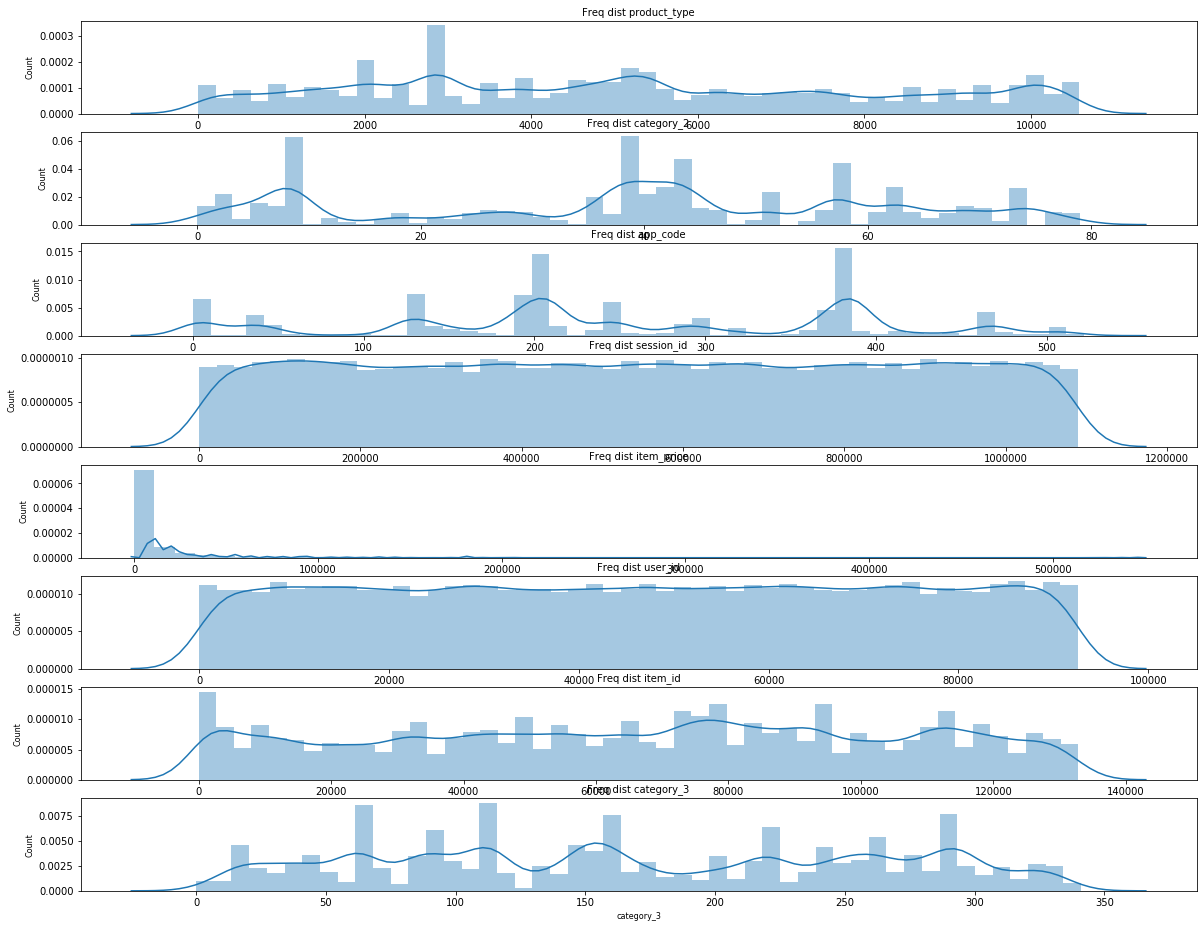

In [118]:
numCols = set(X_train.columns) - set(object_cols)
                     
fig, ax = plt.subplots(len(numCols), figsize=(20,16))

for i, col_val in enumerate(numCols):

    sns.distplot(X_train[col_val].dropna(), hist=True, ax=ax[i])
    ax[i].set_title('Freq dist '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

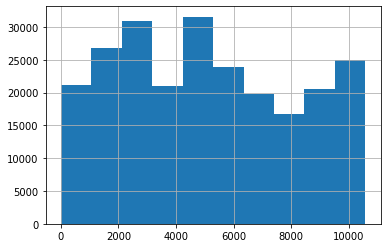

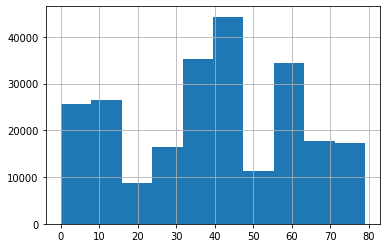

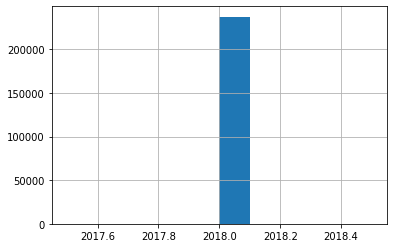

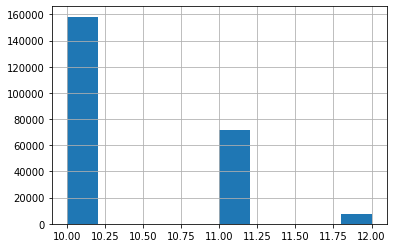

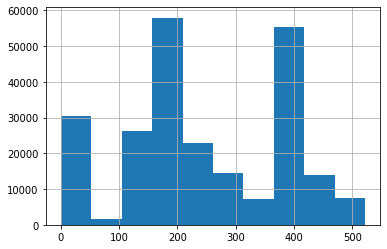

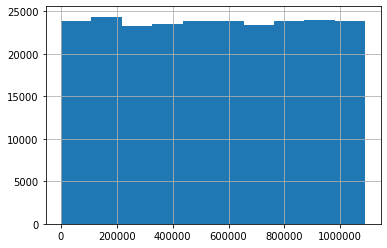

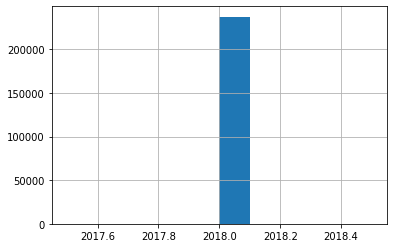

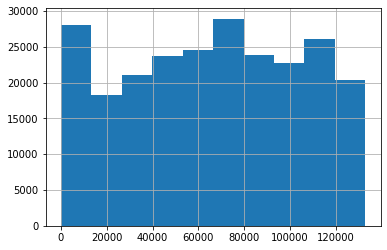

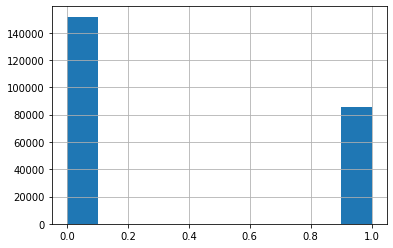

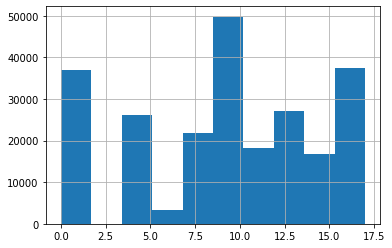

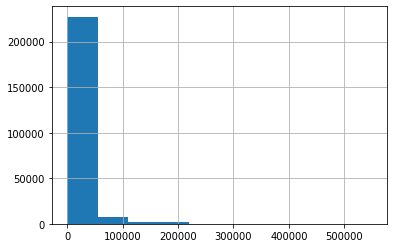

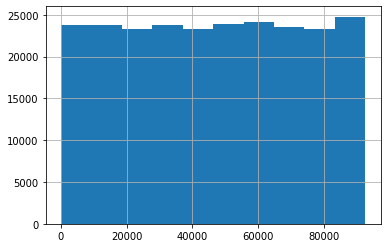

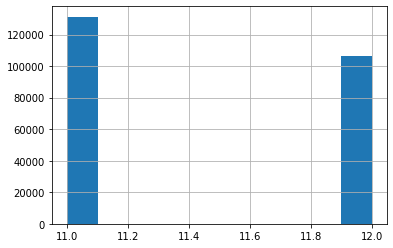

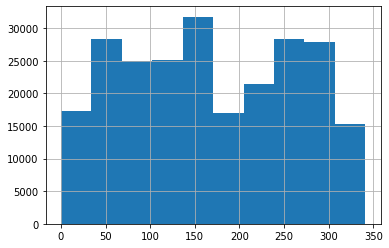

In [82]:
numCols = set(X_train.columns) - set(object_cols)
                    
for i, col_val in enumerate(numCols):
    X_train[col_val].dropna().hist()
    plt.show()

In [ ]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_test_plus = X_test.copy()

In [ ]:
#removing unique id columns
dropCol = ["user_id", "item_id","device_type"]
X_train_plus = X_train_plus.drop(columns = dropCol, errors = "ignore")
X_test_plus = X_test_plus.drop(columns = dropCol, errors = "ignore")

In [109]:
X_train_plus = X_train_plus.replace(to_replace ="missing_value", value =np.NaN)
X_test_plus = X_test_plus.replace(to_replace ="missing_value", value =np.NaN)

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_test_plus[col + '_was_missing'] = X_test_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer(strategy='most_frequent')
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_test_plus = pd.DataFrame(my_imputer.transform(X_test_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_test_plus.columns = X_test_plus.columns

# Imputation
X_train_plus = imputed_X_train_plus.copy()
X_test_plus = imputed_X_test_plus.copy()
my_imputer_1 = SimpleImputer(missing_values = "missing_value", strategy='most_frequent')
imputed_X_train_plus = pd.DataFrame(my_imputer_1.fit_transform(X_train_plus))
imputed_X_test_plus = pd.DataFrame(my_imputer_1.transform(X_test_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_test_plus.columns = X_test_plus.columns

In [110]:
# imputed_X_test_plus.loc[imputed_X_test_plus['item_price'] == "missing_value"].count()
imputed_X_test_plus.loc[imputed_X_test_plus['item_price'] == "missing_value"]

,app_code,os_version,is_4G,session_id,item_price,category_1,category_2,category_3,product_type,serve_month,impression_month,serve_day,impression_day,serve_year,impression_year,item_price_was_missing,category_1_was_missing,category_2_was_missing,category_3_was_missing,product_type_was_missing


In [111]:
#Remaining columns
print(len(imputed_X_test_plus.columns))
print(imputed_X_test_plus.shape)
print("\n")
print(imputed_X_train_plus.shape)
print(imputed_X_train_plus.shape)
print(y.shape)

20
(90675, 20)


(237609, 20)
(237609, 20)
(237609,)


In [112]:
print(imputed_X_train_plus.columns)

Index(['app_code', 'os_version', 'is_4G', 'session_id', 'item_price',
       'category_1', 'category_2', 'category_3', 'product_type', 'serve_month',
       'impression_month', 'serve_day', 'impression_day', 'serve_year',
       'impression_year', 'item_price_was_missing', 'category_1_was_missing',
       'category_2_was_missing', 'category_3_was_missing',
       'product_type_was_missing'],
      dtype='object')


In [95]:
imputed_X_train_plus.head()

,app_code,os_version,is_4G,session_id,item_price,category_1,category_2,category_3,product_type,serve_month,impression_month,serve_day,impression_day,serve_year,impression_year,item_price_was_missing,category_1_was_missing,category_2_was_missing,category_3_was_missing,product_type_was_missing
0,422,old,0,190710,2350,11,35,20,5622,10,11,Friday,Thursday,2018,2018,False,False,False,False,False
1,467,latest,1,356854,3421,4,74,292,577,10,11,Sunday,Thursday,2018,2018,False,False,False,False,False
2,259,intermediate,1,658178,973,13,67,170,2874,10,11,Tuesday,Thursday,2018,2018,False,False,False,False,False
3,244,latest,1,943856,3008,11,51,220,8557,11,11,Sunday,Thursday,2018,2018,False,False,False,False,False
4,473,latest,0,342525,3187,9,9,244,10412,10,11,Thursday,Thursday,2018,2018,False,False,False,False,False


In [119]:
for col in X_train.columns:
    print("{} type = {} ".format(col,X_train[col].dtype))

app_code type = object 
os_version type = object 
is_4G type = object 
session_id type = object 
item_price type = object 
category_1 type = object 
category_2 type = object 
category_3 type = object 
product_type type = object 
serve_month type = object 
impression_month type = object 
serve_day type = object 
impression_day type = object 
serve_year type = object 
impression_year type = object 
item_price_was_missing type = object 
category_1_was_missing type = object 
category_2_was_missing type = object 
category_3_was_missing type = object 
product_type_was_missing type = object 


In [116]:
# All categorical columns
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(X_train[col]) == set(X_test[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be label encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be label encoded: ['os_version', 'is_4G', 'device_type', 'serve_month', 'serve_day', 'impression_day', 'serve_year', 'impression_year']

Categorical columns that will be dropped from the dataset: ['impression_month', 'category_1']


In [120]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('serve_year', 1),
 ('impression_year', 1),
 ('is_4G', 2),
 ('impression_month', 2),
 ('os_version', 3),
 ('device_type', 3),
 ('serve_month', 3),
 ('serve_day', 7),
 ('impression_day', 7),
 ('category_1', 15)]

In [121]:
# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(X_train[col]) == set(X_test[col])]
good_label_cols

['os_version',
 'is_4G',
 'device_type',
 'serve_month',
 'serve_day',
 'impression_day',
 'serve_year',
 'impression_year']

In [122]:
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
bad_label_cols

['impression_month', 'category_1']

In [123]:
print('Categorical columns that will be label encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be label encoded: ['os_version', 'is_4G', 'device_type', 'serve_month', 'serve_day', 'impression_day', 'serve_year', 'impression_year']

Categorical columns that will be dropped from the dataset: ['impression_month', 'category_1']


In [124]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 20]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['os_version', 'is_4G', 'device_type', 'category_1', 'serve_month', 'impression_month', 'serve_day', 'impression_day', 'serve_year', 'impression_year']

Categorical columns that will be dropped from the dataset: []


In [134]:
low_cardinality_cols = set(low_cardinality_cols) - set(dropCol)
low_cardinality_cols

{'category_1',
 'impression_day',
 'impression_month',
 'impression_year',
 'is_4G',
 'os_version',
 'serve_day',
 'serve_month',
 'serve_year'}

In [159]:
trainTestDF = pd.concat([imputed_X_train_plus, imputed_X_test_plus])
print(trainTestDF.shape)
print(imputed_X_train_plus.shape)
print(imputed_X_test_plus.shape)

(328284, 20)
(237609, 20)
(90675, 20)


In [128]:
trainTestDF.head()

,app_code,os_version,is_4G,session_id,item_price,category_1,category_2,category_3,product_type,serve_month,impression_month,serve_day,impression_day,serve_year,impression_year,item_price_was_missing,category_1_was_missing,category_2_was_missing,category_3_was_missing,product_type_was_missing
0,422,old,0,190710,2350,11,35,20,5622,10,11,Friday,Thursday,2018,2018,False,False,False,False,False
1,467,latest,1,356854,3421,4,74,292,577,10,11,Sunday,Thursday,2018,2018,False,False,False,False,False
2,259,intermediate,1,658178,973,13,67,170,2874,10,11,Tuesday,Thursday,2018,2018,False,False,False,False,False
3,244,latest,1,943856,3008,11,51,220,8557,11,11,Sunday,Thursday,2018,2018,False,False,False,False,False
4,473,latest,0,342525,3187,9,9,244,10412,10,11,Thursday,Thursday,2018,2018,False,False,False,False,False


In [157]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_trainTestDF = pd.DataFrame(OH_encoder.fit_transform(trainTestDF[low_cardinality_cols]))

# # One-hot encoding removed index; put it back
OH_cols_trainTestDF.index = trainTestDF.index

# # Remove categorical columns (will replace with one-hot encoding)
num_trainTestDF = trainTestDF.drop(object_cols, axis=1, errors = 'ignore')

# # Add one-hot encoded columns to numerical features
OH_X_trainTestDF = pd.concat([num_trainTestDF, OH_cols_trainTestDF], axis=1)

print(OH_X_trainTestDF.shape)
OH_X_train = OH_X_trainTestDF.iloc[0:237609]
OH_X_test = OH_X_trainTestDF.iloc[237609:]

(328284, 52)


In [160]:
print(len(OH_X_train.columns))
# All categorical columns
print([col for col in imputed_X_test_plus.columns if imputed_X_test_plus[col].dtype == "object"])
OH_X_train.head()

52
['app_code', 'os_version', 'is_4G', 'session_id', 'item_price', 'category_1', 'category_2', 'category_3', 'product_type', 'serve_month', 'impression_month', 'serve_day', 'impression_day', 'serve_year', 'impression_year', 'item_price_was_missing', 'category_1_was_missing', 'category_2_was_missing', 'category_3_was_missing', 'product_type_was_missing']


,app_code,session_id,item_price,category_2,category_3,product_type,item_price_was_missing,category_1_was_missing,category_2_was_missing,category_3_was_missing,...,31,32,33,34,35,36,37,38,39,40
0,422,190710,2350,35,20,5622,False,False,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,467,356854,3421,74,292,577,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,259,658178,973,67,170,2874,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,244,943856,3008,51,220,8557,False,False,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,473,342525,3187,9,244,10412,False,False,False,False,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
# print(set(OH_X_train['item_price']))
OH_X_train.loc[OH_X_train['item_price'] == "missing_value"].count()

app_code                    0
session_id                  0
item_price                  0
category_2                  0
category_3                  0
product_type                0
item_price_was_missing      0
category_1_was_missing      0
category_2_was_missing      0
category_3_was_missing      0
product_type_was_missing    0
0                           0
1                           0
2                           0
3                           0
4                           0
5                           0
6                           0
7                           0
8                           0
9                           0
10                          0
11                          0
12                          0
13                          0
14                          0
15                          0
16                          0
17                          0
18                          0
19                          0
20                          0
21                          0
22        

In [162]:
OH_X_train = OH_X_train*1
OH_X_train = OH_X_train.apply(pd.to_numeric)

# Number of missing values in each column of training data
missing_val_count_by_column = (OH_X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


In [163]:
print(len(OH_X_train.columns))
# All categorical columns
print([col for col in OH_X_train.columns if OH_X_train[col].dtype == "object"])
OH_X_train.head()

52
[]


,app_code,session_id,item_price,category_2,category_3,product_type,item_price_was_missing,category_1_was_missing,category_2_was_missing,category_3_was_missing,...,31,32,33,34,35,36,37,38,39,40
0,422,190710,2350.0,35.0,20.0,5622.0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,467,356854,3421.0,74.0,292.0,577.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,259,658178,973.0,67.0,170.0,2874.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,244,943856,3008.0,51.0,220.0,8557.0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,473,342525,3187.0,9.0,244.0,10412.0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0    226747
1     10862
Name: is_click, dtype: int64

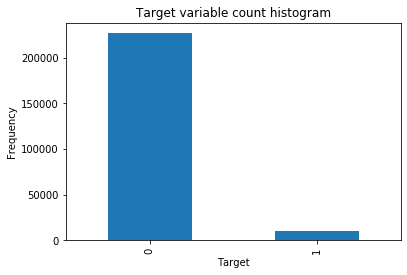

In [164]:
pd.value_counts(y).plot.bar()
plt.title('Target variable count histogram')
plt.xlabel('Target')
plt.ylabel('Frequency')
y.value_counts()

In [165]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 10, num = 5)]

In [166]:
n_estimators

[100, 144, 188, 233, 277, 322, 366, 411, 455, 500]

In [167]:
max_depth

[3, 4, 6, 8, 10]

In [168]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.5, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.8, 1.0],
        'max_depth': max_depth,
        'eta': [0.01, 0.05, 0.1, 0.2],
        'n_estimators' : n_estimators,
        'learning_rate': [0.01, 0.1, 0.2, 0.3]
        }

In [169]:
xgb = XGBClassifier(objective='binary:logistic',
                    silent=True, n_jobs=1)

In [170]:
folds = 3
param_comb = 10

In [171]:
sm = SMOTE(random_state=2)
X_SMOTE, y_SMOTE = sm.fit_sample(OH_X_train, y)

In [172]:
X_SMOTE.shape

(453494, 52)

In [173]:
OH_X_test = OH_X_test*1
OH_X_test = OH_X_test.apply(pd.to_numeric)

In [174]:
X_SMOTE=pd.DataFrame(data=X_SMOTE[0:,0:],index=[i for i in range(X_SMOTE.shape[0])],columns=OH_X_train.columns)

In [175]:
random_search_smote = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=2, cv=3, verbose=5, random_state=1001 )
random_search_smote.fit(X_SMOTE, y_SMOTE)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 42.4min
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 83.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0...
                   param_distributions={'colsample_bytree': [0.5, 0.8, 1.0],
                                        'eta': [0.01, 0.05, 0.1, 0.2],
                                        'gamma': [0.5, 1, 1.5, 2],
       

In [176]:
print('\n All results:')
print(random_search_smote.cv_results_)
print('\n Best Score')
print(random_search_smote.best_score_)
print('\n Best estimator:')
print(random_search_smote.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search_smote.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search_smote.best_params_)
results_smote = pd.DataFrame(random_search_smote.cv_results_)
results_smote.sort_values(by=['rank_test_score']).head(3)


 All results:
{'mean_fit_time': array([202.33533001, 848.86176292,  87.45612105, 309.56986968,
       318.70475761, 778.86456426, 140.52559996, 356.72688937,
       175.36587389,  74.95691943]), 'std_fit_time': array([25.61549184, 43.01121413,  8.2462176 , 15.17445208, 33.22961798,
       21.27977845,  5.05767797,  6.86478187,  2.10121671,  6.83857392]), 'mean_score_time': array([ 1.83056935,  6.87370571,  0.74032108,  2.19974184,  3.57228971,
       11.18676456,  1.69561609,  4.24854302,  1.27295097,  0.65479787]), 'std_score_time': array([0.32770759, 1.4232245 , 0.09657435, 0.33234913, 0.22260825,
       2.28952716, 0.03582129, 0.21452455, 0.01205948, 0.09364443]), 'param_subsample': masked_array(data=[0.5, 1.0, 0.8, 1.0, 1.0, 0.5, 0.5, 1.0, 0.8, 0.8],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[144, 322, 100, 366, 322, 366, 100,

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_eta,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,778.864564,21.279778,11.186765,2.289527,0.5,366,1,10,0.3,0.5,0.01,0.8,"{'subsample': 0.5, 'n_estimators': 366, 'min_c...",0.940405,0.999861,0.993962,0.978076,0.026746,1
4,318.704758,33.229618,3.572290,0.222608,1,322,1,6,0.1,0.5,0.01,0.5,"{'subsample': 1.0, 'n_estimators': 322, 'min_c...",0.937905,0.999251,0.988347,0.975168,0.026722,2
3,309.569870,15.174452,2.199742,0.332349,1,366,1,3,0.3,2,0.1,0.8,"{'subsample': 1.0, 'n_estimators': 366, 'min_c...",0.937419,0.997980,0.987799,0.974399,0.026477,3


In [ ]:
len(X_SMOTE.columns)
# All categorical columns
print([col for col in X_SMOTE.columns if X_SMOTE[col].dtype == "object"])
X_SMOTE.head()

In [177]:
y_test = random_search_smote.predict_proba(OH_X_test)
results_df = pd.DataFrame(data={'impression_id':testDF['impression_id'], 'is_click':y_test[:,1]})
print(results_df.shape)
results_df.to_csv('/Users/raghugup/Downloads/submission_format-111122.csv', index=False)

(90675, 2)


In [178]:
# Get the best parameters
random_search_params_smote = results_smote.loc[1, 'params']
xgb_best_smote = XGBClassifier(**random_search_params_smote, objective='binary:logistic',
                    silent=True, n_jobs=5)
xgb_best_smote.fit(X_SMOTE, y_SMOTE)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eta=0.01, gamma=0.5,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=322, n_jobs=5,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1.0, verbosity=1)

[0.00436775 0.00110682 0.00111442 0.00124487 0.00106602 0.00105384
 0.         0.         0.         0.         0.         0.05288106
 0.04141974 0.03955924 0.05741568 0.05060175 0.11160981 0.04129291
 0.01435123 0.2583211  0.00841032 0.         0.07271112 0.00450485
 0.00093318 0.         0.07186215 0.         0.1110861  0.
 0.00373326 0.00616967 0.00311095 0.00332158 0.00186424 0.00629698
 0.00309227 0.00082644 0.0015504  0.00327637 0.00133131 0.00127191
 0.00107415 0.00256928 0.00097062 0.00311592 0.00119641 0.00131573
 0.00178281 0.0012851  0.00085773 0.00307293]
[('app_code', 0.004367745), ('session_id', 0.0011068191), ('item_price', 0.0011144159), ('category_2', 0.0012448718), ('category_3', 0.0010660163), ('product_type', 0.0010538441), ('item_price_was_missing', 0.0), ('category_1_was_missing', 0.0), ('category_2_was_missing', 0.0), ('category_3_was_missing', 0.0), ('product_type_was_missing', 0.0), (0, 0.05288106), (1, 0.041419737), (2, 0.039559238), (3, 0.057415683), (4, 0.05

Text(0.5, 0, 'relative importance')

<Figure size 432x288 with 0 Axes>

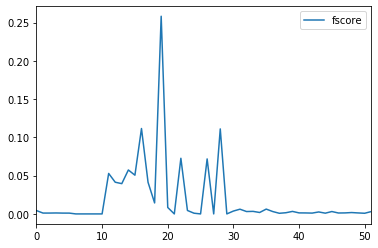

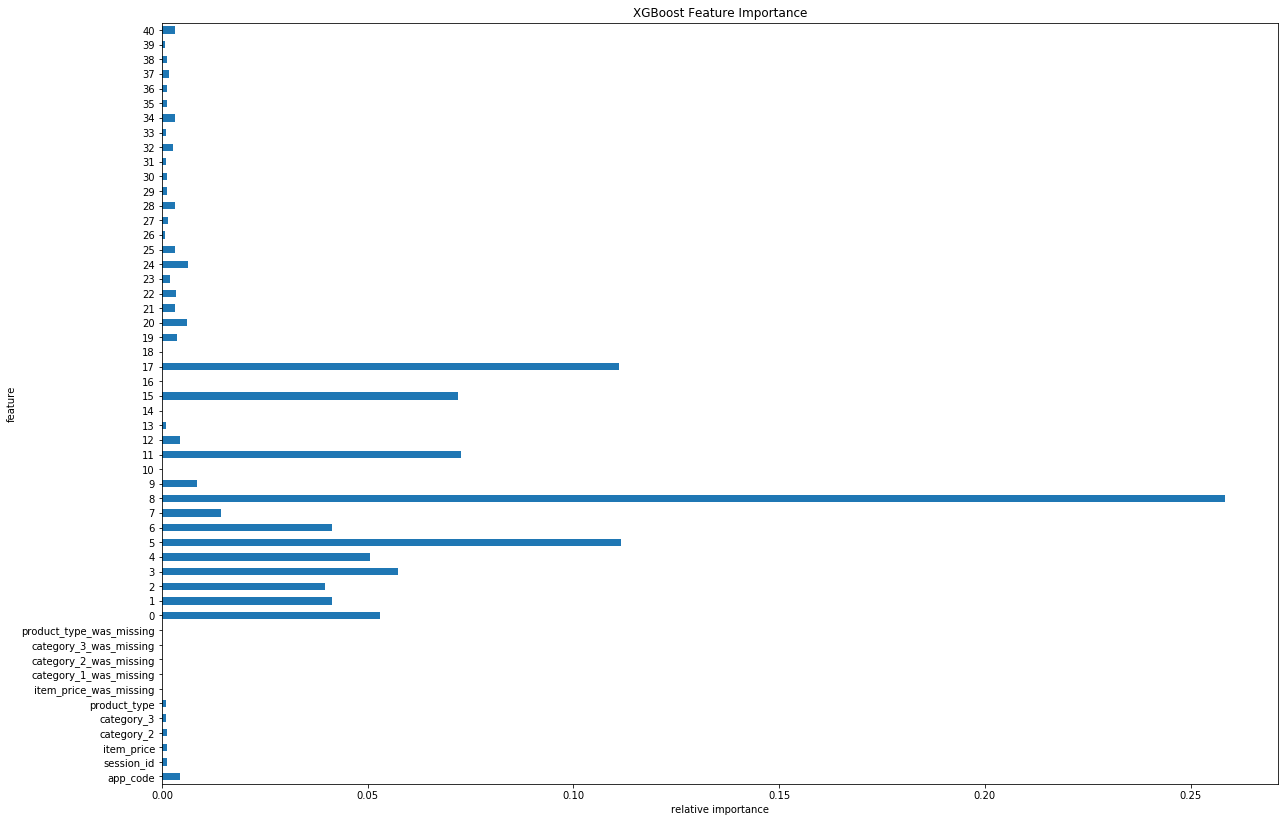

In [179]:
# feature importance
print(xgb_best_smote.feature_importances_)
featureTuples = []
i = 0
for col in X_SMOTE.columns:
    featureTuples.append((col, xgb_best_smote.feature_importances_[i]))
    i = i + 1
print(featureTuples)
df = pd.DataFrame(featureTuples, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(20, 14))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

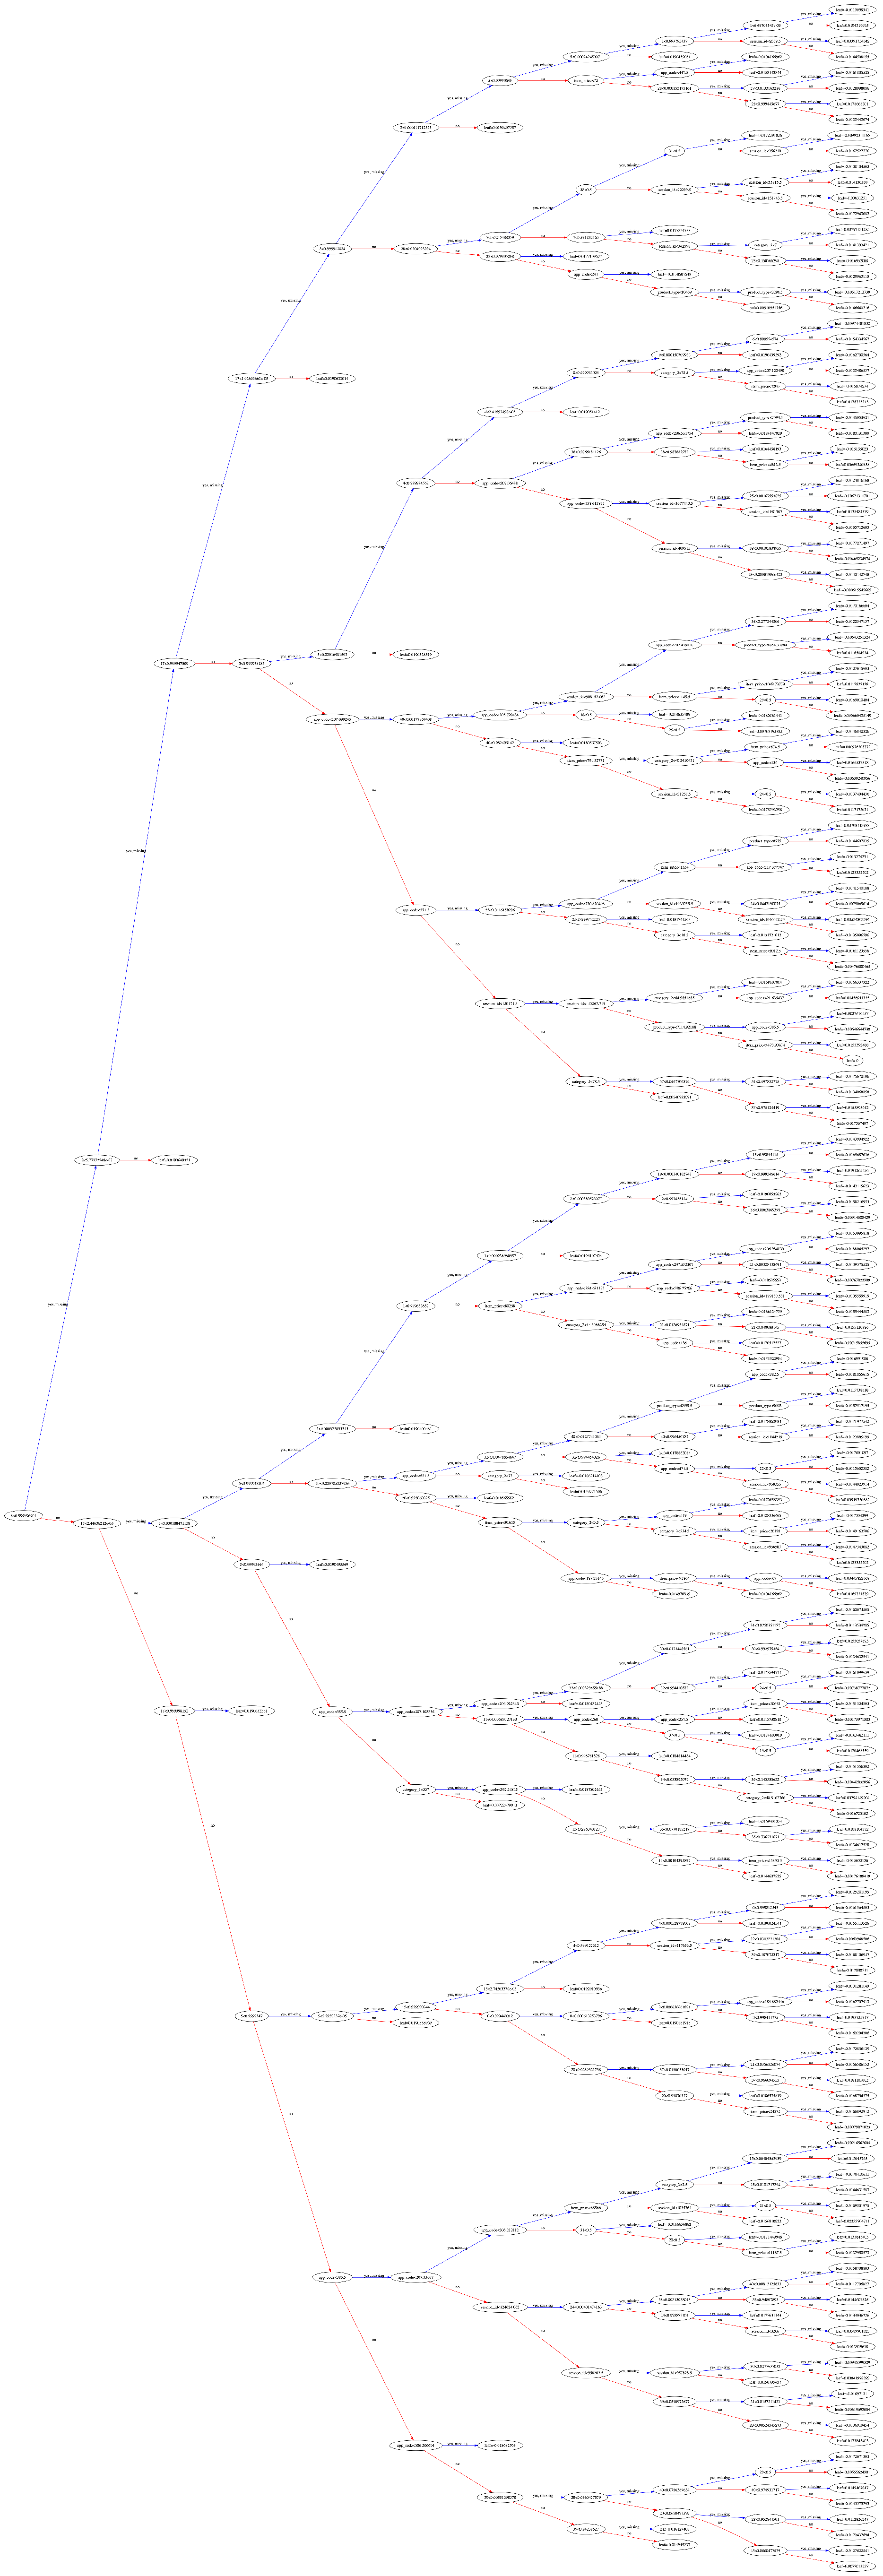

In [180]:
#print 5th boosted tree
plot_tree(xgb_best_smote, num_trees= 5, rankdir='LR')
# plt.savefig("/Users/raghugup/Downloads/xgb_best.png", format='png', dpi=2000)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('/Users/raghugup/Downloads/tree.png')